# Tutorial : IDEAS usage

## Imports

In [18]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from functions_IDEAS import compute_ID
from utils_IDEAS import *

## Usage

To show a simple example, let's consider two clusters from the dataset [Tran et al.](https://doi.org/10.1016/j.celrep.2019.04.056): cluster 1, mainly consisting of mouse embryonic fibroblasts (MEFs) and cluster 5, mainly consisting of mouse embyonic stem cells (mESCs). 

In [19]:
adata_fbs=sc.read('../Datasets/FBS_IDEAS.h5ad')
adata = adata_fbs[(adata_fbs.obs.cluster == '1')|(adata_fbs.obs.cluster == '5')]

In [29]:
adata.obs.head()

,medium,day,replicate,cell_type,n_counts,log_counts,n_genes,mt_frac,cluster,pluripotency,naive_pluripotency,cluster_pluripotency,cluster_naive_pluripotency,dpt_pseudotime
CellId,,,,,,,,,,,,,,
atccggctcaatgccgtt,FBS,3,2,MEF,37924,10.543339,6807,0.0,1,0.178802,0.123372,0.148889,0.16011,0.024957
aagccataagctcgttat,FBS,3,2,MEF,25678,10.153390,5910,0.0,1,0.253132,0.216602,0.148889,0.16011,0.152912
cgaaagaacgtgtgcggt,FBS,3,2,MEF,23815,10.078071,5888,0.0,1,0.220179,0.204298,0.148889,0.16011,0.157187
ctattacttgaagcgcgg,FBS,3,2,MEF,21373,9.969884,5541,0.0,1,0.208722,0.208504,0.148889,0.16011,0.153057
agcacggtggtgtggcag,FBS,3,2,MEF,20260,9.916404,5442,0.0,1,0.331684,0.308091,0.148889,0.16011,0.155688


Visualize the two clusters in a UMAP projection:

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


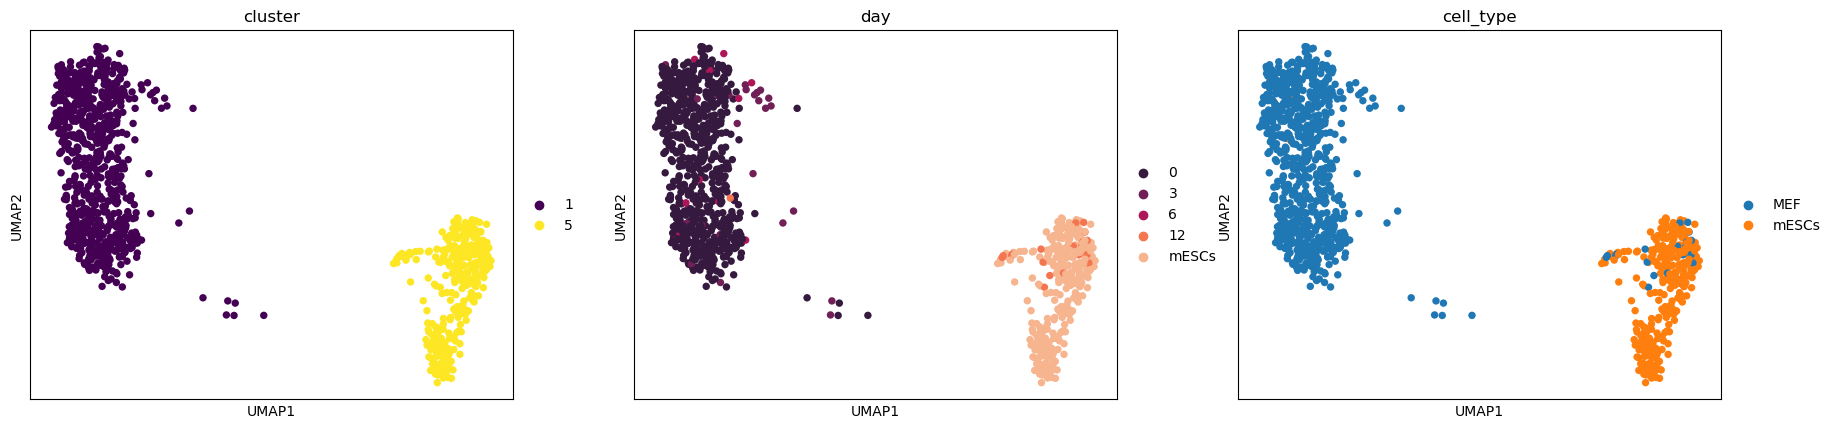

In [27]:
sc.pl.umap(adata, color = ['cluster', 'day', 'cell_type'])

### Cluster-based approach

Let's use IDEAS to compute the intrinsic dimension (ID) of each cluster. IDEAS takes in input the raw counts matrix. The default method is [TWO-NN](https://doi.org/10.1038/s41598-017-11873-y)('2nn'), but also the PCA ('pca') one can be selected. In the cluster-based approach, multiple random sub-samplings are performed and the ID is estimated on each sample. We can set the number of samples with the n_samples parameter and the sample size with the sample_size parameter:

In [30]:
sample_size = 140
n_samples = 200

id_2nn = compute_ID(adata, group = 'cluster', method='2nn', sample_size=sample_size, n_samples = n_samples, full_output = True, id_score=True)


Computing ID for cluster 1:


100%|██████████| 200/200 [00:05<00:00, 34.71it/s]


Computing ID for cluster 5:


Computing Intrinsic Dimension: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


The ouput of IDEAS is a Pandas Dataframe which has the cluster names as columns and the ID estimation for each sample as rows:

In [31]:
id_2nn

,1,5
1,0.099136,0.626976
2,0.112580,0.647874
3,0.120521,0.692885
4,0.140707,0.705975
5,0.126427,0.514116
...,...,...
196,0.112948,0.477821
197,0.161268,0.623958
198,0.174893,0.609214
199,0.125402,0.633590


The result can be visualized with a boxplot. Having set the parameter id_score to True, the values are rescaled in the [0,1] range:

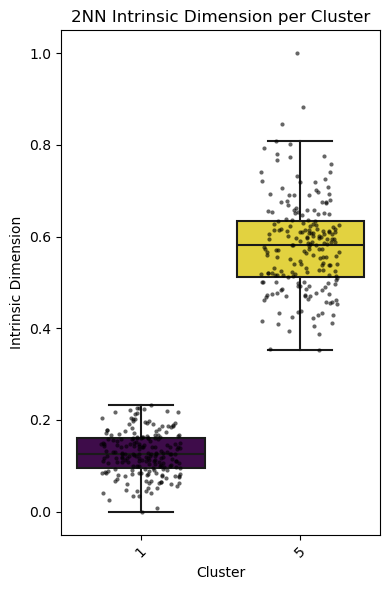

In [37]:

id_2nn_long = id_2nn.melt(var_name='Cluster', value_name='ID')
colors = sns.color_palette("viridis", n_colors=256)
palette = [colors[0], colors[-1]]

# Plot
plt.figure(figsize=(4, 6))
sns.boxplot(data=id_2nn_long, x='Cluster', y='ID', showfliers=False, palette=palette)
sns.stripplot(data=id_2nn_long, x='Cluster', y='ID', color='black', jitter=0.25, size=3, alpha=0.6)

plt.title('2NN Intrinsic Dimension per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Intrinsic Dimension')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As expeted, cluster 5, which contains mainly stem cells, has a higher ID, reflecting its higher potency level respect to the fibroblasts cluster (cluster 1).

If one wants to direcly access the mean and standard deviation for each cluster, the full_output parameter should be set to False:

In [41]:
id_2nn_f = compute_ID(adata, group = 'cluster', method='2nn', sample_size=sample_size, n_samples = n_samples, full_output = False, id_score = True)

Computing Intrinsic Dimension:   0%|          | 0/2 [00:00<?, ?it/s]

Computing ID for cluster 1:


Computing Intrinsic Dimension:  50%|█████     | 1/2 [00:05<00:05,  5.52s/it]

Computing ID for cluster 5:


Computing Intrinsic Dimension: 100%|██████████| 2/2 [00:10<00:00,  5.49s/it]


In [42]:
id_2nn_f

,1,5
Mean Intrinsic Dimension,0.103132,0.633778
Standard Deviation,0.053369,0.117019


### Single cell approach

A different approach would be to ignore the clustering and use IDEAS as a single cell tool, attributing a value of ID to each single cell and inspecting weather the two populations of cells become distinguishable in a unsupervised way. To do so, one can use the local version of ID, via the 'local_2nn' or 'local_pca' methods. In this case, the number of neighbors for the local ID measurement has to be set:

In [43]:
N = 100
id_local_2nn = compute_ID(adata, method='local_2nn', n_neighbors = N, id_score = True)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [00:22<00:00, 22.76s/it]


The ouput contains a measure of ID for each cell, indexed by its barcode (or obs name):

In [44]:
id_local_2nn

,ID
atccggctcaatgccgtt,0.483054
aagccataagctcgttat,0.445897
cgaaagaacgtgtgcggt,0.413982
ctattacttgaagcgcgg,0.411357
agcacggtggtgtggcag,0.342914
...,...
tagaggaacgtgttcgca,0.196863
gaaggggcgcggtaagct,0.093617
ctattaccgatgttgctc,0.124543
gcgcggtcgcctgactcg,0.355168


Add the ID as a obs column in the AnnData Object and visualize the local ID in a UMAP:

In [45]:
add_local_ID_to_adata(adata, id_local_2nn, N)

AnnData object with n_obs × n_vars = 1049 × 24421
    obs: 'medium', 'day', 'replicate', 'cell_type', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'cluster', 'pluripotency', 'naive_pluripotency', 'cluster_pluripotency', 'cluster_naive_pluripotency', 'dpt_pseudotime', 'local_ID_100'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'day_colors', 'hvg', 'log1p', 'cell_type_colors'
    obsm: 'X_diffmap', 'X_umap'

In [47]:
adata.obs.local_ID_100

CellId
atccggctcaatgccgtt    0.483054
aagccataagctcgttat    0.445897
cgaaagaacgtgtgcggt    0.413982
ctattacttgaagcgcgg    0.411357
agcacggtggtgtggcag    0.342914
                        ...   
tagaggaacgtgttcgca    0.196863
gaaggggcgcggtaagct    0.093617
ctattaccgatgttgctc    0.124543
gcgcggtcgcctgactcg    0.355168
atacttatgaagattagt    0.393378
Name: local_ID_100, Length: 1049, dtype: float64

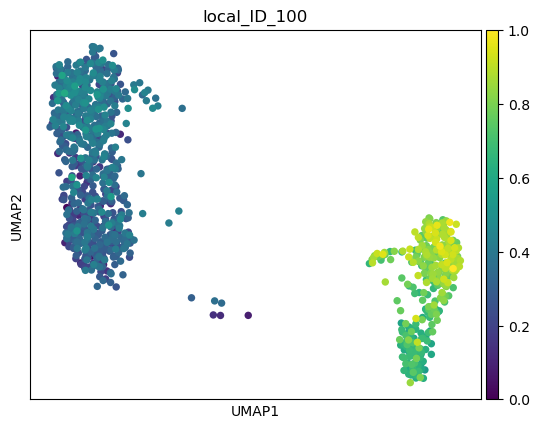

In [48]:
sc.pl.umap(adata, color = 'local_ID_100')

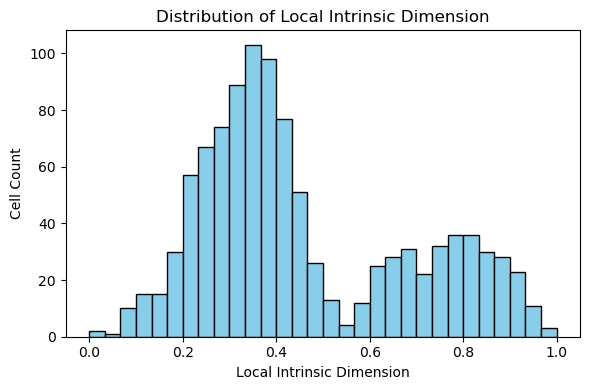

In [60]:
plt.figure(figsize=(6, 4))
plt.hist(adata.obs.local_ID_100.dropna(), bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Local Intrinsic Dimension', fontsize=12)
plt.xlabel('Local Intrinsic Dimension', fontsize=10)
plt.ylabel('Cell Count', fontsize=10)

plt.tight_layout()
plt.show()

The same analysis can be performed with the PCA-based method. Since it is less efficient than the TWO-NN one, a solution could be to perform the analysis on a subset of cells. In general, one can specify the cells for which to calculate the local ID by passing the list of obs_names to the 'roots' parameter:

In [49]:
#select half of the cells (randomly)
roots = random.sample(list(adata.obs_names), k = len(adata) // 2)

In [50]:
id_local_pca = compute_ID(adata, method='local_pca', roots = roots, n_neighbors = N, id_score = True)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [01:07<00:00, 67.44s/it]


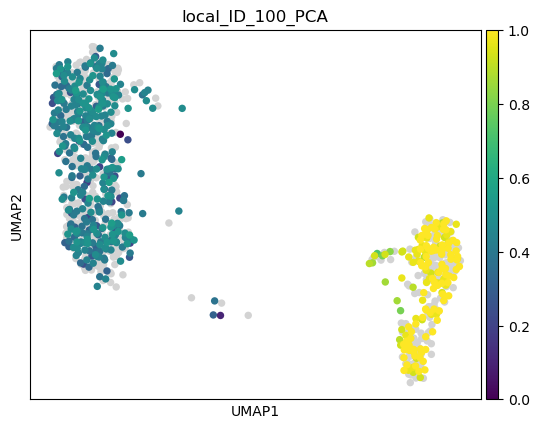

In [51]:
add_local_ID_to_adata(adata, id_local_pca, N, column_name = 'local_ID_100_PCA')
sc.pl.umap(adata, color = 'local_ID_100_PCA')

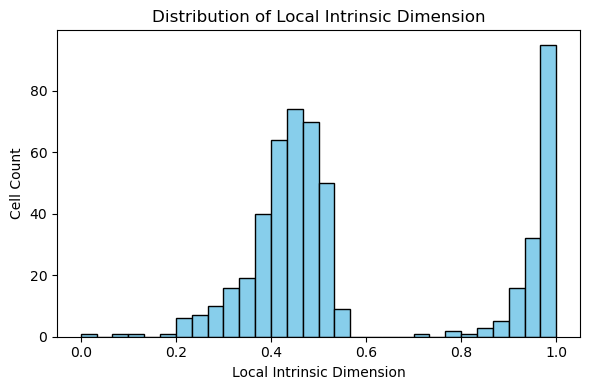

In [61]:
plt.figure(figsize=(6, 4))
plt.hist(adata.obs.local_ID_100_PCA.dropna(), bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Local Intrinsic Dimension', fontsize=12)
plt.xlabel('Local Intrinsic Dimension', fontsize=10)
plt.ylabel('Cell Count', fontsize=10)

plt.tight_layout()
plt.show()